# P2PSimpy Services 

Service is a key component to the simulation that helps to define a running scenario for your experiment.
Each service has access to peer class and Simpy environment. 

At the moment simulation has two abstract service classes: 
1. Runner  
2. Handler


**Runner**

Typically runner works as a producer of events, or when you require an action initiative from a peer. For example, a message producer is a runner.

Function to implement: *run()*.


**Handler**

Handler works as a reactive service that handles upcoming messages. 

Functions to implement: 
 - handle_message(msg) - react upon recieving a message.
 - @property messages - list of messages that this service can handle.  



For example, connection managers is both a runner and a handler as it produces and reacts on messages. 

# Creating new services



The simulation at this point is not useful yet. 
Let's create own service on top of what we have now: let's build a gossip network.

This is an important building block which in different forms in almost any p2p system ([wiki](https://en.wikipedia.org/wiki/Gossip_protocol), [hyperledger gossip](https://hyperledger-fabric.readthedocs.io/en/release-1.4/gossip.html), [course slides](http://www.cs.cornell.edu/courses/cs6410/2016fa/slides/19-p2p-gossip.pdf)). 


## Gossip Message Handler

There are multiple ways to implement Gossip: [ttl, anti-entropy etc](http://www.cs.cornell.edu/Projects/Quicksilver/public_pdfs/2007PromiseAndLimitations.pdf).

We will implement one of the simplest versions with ttl (Time to live), where each message has a predefined $ttl$ parameter. Ttl shows a stoping condition for the peer, i.e. if ttl=0 peer should stop, otherwise ttl must be decremented and the message gossiped further.


Let's first implement a handler: a service that reacts on incoming gossip messages: 


In [1]:
# Message gossip
from p2psimpy.services.base import BaseHandler
from p2psimpy.messages import BaseMessage
from p2psimpy.storage import Storage

from re import split 
from copy import copy

# Define a special message GossipMessage: Message with ttl


class GossipMessage(BaseMessage):

    __slots__ = ('sender', 'data', 'ttl')
    size = 1024
    
    def __init__(self, sender, data, ttl):
        super().__init__(sender, data)
        self.ttl = ttl
        
class GossipService(BaseHandler):
    """
    Simple gossip service to handle gossip messages and rely them to neighbors. 
    """

    def __init__(self, peer, fanout=3, exclude_peers: set=None, exclude_types: set=None):
        super().__init__(peer)
        
        self.fanout = fanout
        if exclude_peers is None:
            self.exclude_peers = set() 
        else:
            self.exclude_peers = exclude_peers
        self.exclude_types = exclude_types
        
        self.strg_name = 'msg_time'
        self.peer.add_storage(self.strg_name, Storage())

    def handle_message(self, msg):
        # Store message localy 
        msg_id = msg.data
        self.peer.store(self.strg_name, msg_id, self.peer.env.now)
        if msg.ttl > 0:
            # Rely message further, modify the message
            exclude_peers = {msg.sender} | self.exclude_peers
            # Use peer gossip - it will sample self.config.fanout and exclude sender
            # If you need to exclude some peers: add it to the set
            self.peer.gossip( GossipMessage(self.peer, msg.data, msg.ttl-1), 
                             self.fanout, except_peers=exclude_peers, except_type=self.exclude_types)

    @property
    def messages(self):
        return GossipMessage,


Peer object has a gossip function that will send message to random sample of `fanout` connected peers.
Peers are excluded `except_peers` and `except_type` from the sampling. 

This is a basic service to relay messages to the random peers.



## Message producer 

GossipService ensures that message will spread in the network. 

But to first start the gossip message we need a message producer. 
We will inherit it from a `BaseRunner` class.

MessageProducer will have msg rate, ttl and fanout and a timeout for start.




In [2]:
from p2psimpy.services.base import BaseRunner

class MessageProducer(BaseRunner):

    def __init__(self, peer, init_timeout=1000, msg_rate=5, init_ttl=3, init_fanout=10):
        super().__init__(peer)
        # calculate tx_interval
        self.init_timeout = init_timeout
        self.init_ttl = init_ttl
        self.init_fanout = init_fanout
        
        self.tx_interval = 1000 / msg_rate
        self.counter = 1 
        
        # Let's add a storage layer to store messages
        self.strg_name = 'msg_time'
        self.peer.add_storage(self.strg_name, Storage())


    def produce_transaction(self):
        
        self.peer.gossip(GossipMessage(self.peer,
                                       '_'.join((str(self.counter), str(self.peer.peer_id))), 
                                       self.init_ttl), 
                         self.init_fanout)
        self.peer.store(self.strg_name, str(self.counter), self.peer.env.now)
        self.counter+=1
        

    def run(self):
        yield self.env.timeout(self.init_timeout)
        while True:
            self.produce_transaction()
            yield self.env.timeout(self.tx_interval)

## Preparing experiment

In [3]:
# Define locations 
from p2psimpy.config import *
from p2psimpy.consts import *
from p2psimpy.services.connection_manager import BaseConnectionManager
import networkx as nx
from random import choice

import matplotlib.pyplot as plt
        
class Locations(Config):
    locations = ['Ohio', 'Ireland', 'Tokyo']
    latencies = {
        'Ohio': {'Ohio': Dist('invgamma', (5.54090, 0.333305, 0.987249)),
                 'Ireland': Dist('norm', (73.6995, 1.19583092197097127)),
                 'Tokyo': Dist('norm', (156.00904977375566, 0.09469886668079797))
                },
        'Ireland':{'Ireland': Dist('invgamma', (6.4360455224301525, 0.8312748033308526, 1.086191852963273)),
                   'Tokyo': Dist('norm', (131.0275, 0.25834811785650774))
                  },
        'Tokyo': {'Tokyo':  Dist('invgamma', (11.104508341331055, 0.3371934865734555, 2.0258998705983737))}
    }
    
# Define peer     
class PeerConfig(Config):
    location = Dist('sample', Locations.locations)
    bandwidth_ul = Dist( 'norm', (50*MBit, 10*MBit))
    bandwidth_dl = Dist( 'norm', (50*MBit, 10*MBit))
    
class GossipConfig(Config):
    exclude_types={'client',}

def prepare_peer_types():
    return { 'peer': PeerType(PeerConfig,   {BaseConnectionManager: None,
                                                GossipService: GossipConfig }),
             'client': PeerType(PeerConfig, (BaseConnectionManager, MessageProducer))}

def prepare_topology(num_peers=25, num_clients=1):    
    # Create network topology
    G = nx.erdos_renyi_graph(num_peers, 0.4)   
    nx.relabel_nodes(G, {k: k+1 for k in G.nodes()} ,copy=False)

    client_edges = [(i, choice(list(G.nodes()))) for i in range(num_peers+1, num_clients+num_peers+1)]
    G.add_edges_from(client_edges)

    types_map = {k: 'peer' if k < num_peers+1 else 'client' for k in G.nodes()}
    # Assign a peer type to the peers 
    nx.set_node_attributes(G, types_map , 'type')
    return G

def visualize_peer_client_network(G):
    plt.figure(figsize=(10,10))

    # Draw client/ peer network 

    master_nodes = [n for (n,ty) in \
        nx.get_node_attributes(G,'type').items() if ty == 'peer']
    client_nodes = [n for (n,ty) in \
        nx.get_node_attributes(G,'type').items() if ty == 'client']

    pos = nx.kamada_kawai_layout(G)

    nx.draw_networkx_nodes(G, pos, nodelist=master_nodes, \
        node_color='blue', node_shape='o', node_size=500)
    nx.draw_networkx_nodes(G, pos, nodelist=client_nodes,  \
        node_color='green', node_shape='^', node_size=100, label=1)

    nx.draw_networkx_labels(G, pos, labels={k:k for k in master_nodes}, font_color='w')

    nx.draw_networkx_edges(G, pos, edgelist=G.subgraph(master_nodes).edges(), width=1.5)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(nbunch=client_nodes),  style='dotted')


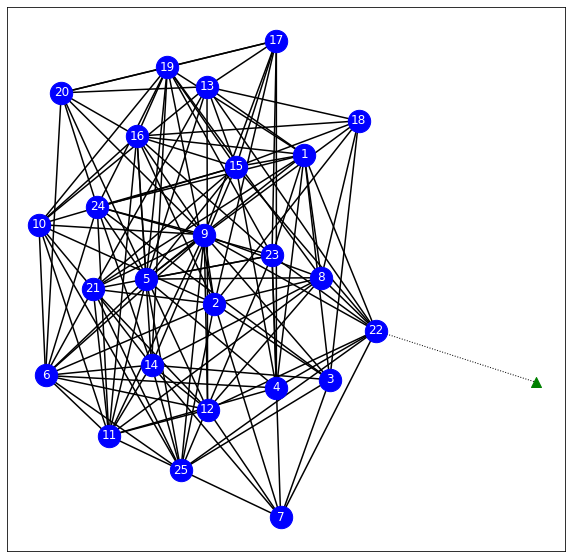

In [4]:
# Prepare and show target network topology 
G = prepare_topology()
visualize_peer_client_network(G)

In [5]:
from time import time
from p2psimpy.simulation import BaseSimulation

net_sim = BaseSimulation(Locations, G, prepare_peer_types())

{'peer': PeerType(config=<class '__main__.PeerConfig'>, service_map={<class 'p2psimpy.services.connection_manager.BaseConnectionManager'>: None, <class '__main__.GossipService'>: <class '__main__.GossipConfig'>}), 'client': PeerType(config=<class '__main__.PeerConfig'>, service_map=(<class 'p2psimpy.services.connection_manager.BaseConnectionManager'>, <class '__main__.MessageProducer'>))}


In [6]:
net_sim.run(5_200)

Let's see if this gossip protocol converges and what is the time for convergence. 


You can inspect time when peer has recorded the message by looking at `peer.storage`.

For this experiment we used simple dictionary *first-seen* storage. 

In [7]:

client_id = 26
print("Time messages produced: \n %s " % net_sim.peers[client_id].storage['msg_time'].txs)

# Put any peer id you want to inspect
peer_id = 1 

print(net_sim.peers[peer_id].storage['msg_time'].txs)

Time messages produced: 
 {'1': 1000, '2': 1200.0, '3': 1400.0, '4': 1600.0, '5': 1800.0, '6': 2000.0, '7': 2200.0, '8': 2400.0, '9': 2600.0, '10': 2800.0, '11': 3000.0, '12': 3200.0, '13': 3400.0, '14': 3600.0, '15': 3800.0, '16': 4000.0, '17': 4200.0, '18': 4400.0, '19': 4600.0, '20': 4800.0, '21': 5000.0} 
{'1_26': 1144.0954728622587, '2_26': 1237.1520571104447, '3_26': 1543.69142388297, '5_26': 1837.4416914309813, '6_26': 2143.9385329267493, '7_26': 2343.884494068843, '8_26': 2436.828243801168, '9_26': 2743.8005239061304, '10_26': 2943.908489360241, '11_26': 3144.329148796741, '13_26': 3544.0241423939683, '15_26': 3837.4204904777607, '17_26': 4343.708338488119, '18_26': 4437.146604472392, '20_26': 4943.884334212565, '21_26': 5143.754226389864}


In [8]:
# Calculate the delay 

def total_delay(sim, peer_id, storage_name):
    store = sim.peers[peer_id].storage[storage_name].txs
    for k, peer_time in store.items():
        msg_num, client_id = k.split('_')
        client_time = sim.peers[int(client_id)].storage[storage_name].txs[msg_num]
        yield (int(msg_num), peer_time - client_time)
        
dict(total_delay(net_sim, peer_id, 'msg_time'))

{1: 144.0954728622587,
 2: 37.15205711044473,
 3: 143.69142388296996,
 5: 37.44169143098134,
 6: 143.9385329267493,
 7: 143.8844940688432,
 8: 36.8282438011679,
 9: 143.80052390613037,
 10: 143.90848936024122,
 11: 144.3291487967408,
 13: 144.0241423939683,
 15: 37.42049047776072,
 17: 143.7083384881189,
 18: 37.14660447239203,
 20: 143.88433421256468,
 21: 143.75422638986402}

In [9]:
dict(total_delay(net_sim, 12, 'msg_time'))

{1: 78.15284749459829,
 2: 78.83855375847952,
 3: 78.22250008847504,
 4: 78.41012299412523,
 5: 78.65098065642405,
 6: 78.45515559321348,
 7: 78.99384392483717,
 8: 78.60184351326052,
 9: 78.50153636355799,
 10: 78.44065387560568,
 11: 78.50171277864683,
 12: 78.22441151218027,
 13: 78.30128600357511,
 17: 78.27198450381911,
 19: 78.32989349151558,
 20: 234.16918277480545,
 21: 78.83273249800186}

Try to play around with different peer_id values. Try peer that directly connected to the client, then try peer on the edge of the network (further from the client).  

____________________________

# Analyze and visualize  gossip


When we implement gossip it is important to analyze following: 
 - What is the average time for the peer to receive a message? 
 - What is the convergence speed for my gossip protocol? 
 - Can we guarantee that all peers will see the message? At what time message is finalized?   


Let's go one by one and answer these questions for this gossip protocol implementation. 


## Convergence

In [10]:
import pandas as pd

def total_delay(sim, peer_id, storage_name):
    store = sim.peers[peer_id].storage[storage_name].txs
    for k, peer_time in store.items():
        msg_num, client_id = k.split('_')
        client_time = sim.peers[int(client_id)].storage[storage_name].txs[msg_num]
        yield (int(msg_num), peer_time - client_time)
        
def get_gossip_table(sim, storage_name):
    return pd.DataFrame({k: dict(total_delay(sim, k, storage_name)) 
                         for k in sim.types_peers['peer']}).sort_index()
df = get_gossip_table(net_sim, 'msg_time')
df

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
1,144.095473,78.834088,78.475793,209.294147,143.680179,78.703862,NaN,78.266656,0.456403,156.574829,...,144.235922,NaN,156.272054,156.285597,156.484935,156.403392,0.205035,NaN,156.527622,78.788470
2,37.152057,78.613069,102.521288,78.381100,143.984424,78.686684,NaN,78.368004,156.301557,73.201677,...,37.613099,144.174188,156.511629,NaN,NaN,NaN,0.365895,NaN,156.608324,78.850663
3,143.691424,78.751088,NaN,78.183082,144.093882,78.684650,156.179979,78.503191,156.196970,156.432034,...,143.939452,143.490573,NaN,NaN,156.432422,156.364095,0.215509,78.229739,156.241295,NaN
4,NaN,78.528800,78.758651,78.273825,144.143230,78.525859,0.457317,NaN,156.295378,156.367741,...,144.197082,143.659184,NaN,156.591688,156.446499,156.383626,0.240340,78.474467,NaN,78.348946
5,37.441691,78.629360,78.680126,NaN,37.360740,78.946598,0.705828,78.871244,0.617270,180.447104,...,37.837619,NaN,NaN,1.354086,NaN,0.978857,0.386831,78.992951,74.167402,78.947917
6,143.938533,209.677844,78.579900,78.571406,143.972264,234.346442,0.601061,NaN,156.334577,181.656475,...,144.026711,143.961416,181.059322,181.303000,156.455633,156.653006,0.358922,78.303736,156.494731,NaN
7,143.884494,NaN,78.872658,78.214178,37.767310,78.456376,NaN,78.670726,0.611349,NaN,...,38.256059,143.703827,0.854477,74.211799,156.461642,NaN,0.224194,209.266771,NaN,NaN
8,36.828244,78.757198,78.494379,101.989198,144.142828,78.459563,0.528244,NaN,0.466558,NaN,...,37.382090,36.363308,74.195276,75.844357,72.886112,156.444097,0.226488,78.510130,156.512548,78.742406
9,143.800524,78.530084,78.513073,NaN,143.665040,NaN,0.474543,78.241933,156.521811,NaN,...,193.569133,143.813560,156.310668,156.473938,NaN,1.064602,0.238329,78.464879,1.031754,78.273545
10,143.908489,78.742597,78.476858,78.551969,NaN,234.233527,0.475049,78.253387,156.281385,156.513814,...,192.181042,143.860327,NaN,156.200945,NaN,156.287972,0.225857,78.272537,156.505562,78.801451


Code above should produce a table with message number on the rows and peer id on the columns. 

You can also probably see `NaN` values in the table. These indicate that gossip protocol didn't converge fully, and some peers never saw some messages. To guarantee convergence we either need to implement fancier gossip based on [set reconciliation](https://www.cse.ust.hk/~yike/sigmod14.pdf)  or tweak the parameters: `fanout` and `ttl`. We need to fine-tune the parameter to achieve required effect. 

Usually gossip is fast to converge, but some slow and peer on the edge of the network might break it.


We can also represent our table as a heatmap. White color corresponds to `Nan`. You can see what peers are slower, or what message is least/most seen:

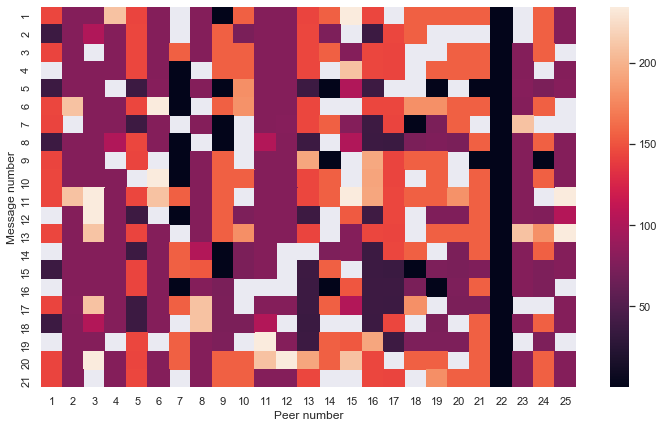

In [11]:
import seaborn as sns
sns.set()

def show_heat_map(df):
    plt.figure(figsize=(12, 7))
    ax = plt.axes()

    sns.heatmap(df, ax=ax)

    plt.xlabel('Peer number', fontsize = 12) # x-axis label with fontsize 15
    plt.ylabel('Message number', fontsize = 12) # y-axis label with fontsize 15

    plt.show()

show_heat_map(df)

## Average time 

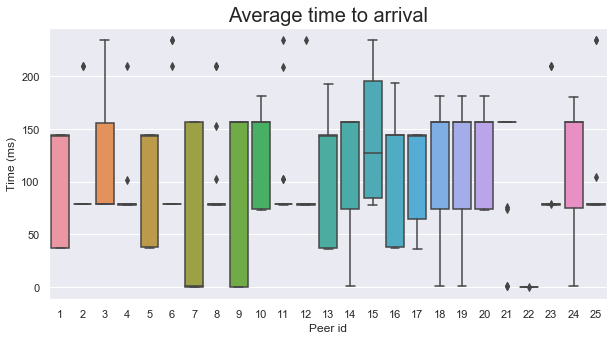

In [12]:
def show_avg_time(df):
    plt.figure(figsize=(10, 5))
    ax = sns.boxplot(data=df, )
    ax.set_title('Average time to arrival', fontsize= 20 )
    ax.set_ylabel('Time (ms)', fontsize=12)
    ax.set_xlabel('Peer id', fontsize=12)
    plt.show()
show_avg_time(df)

## Convergence speed

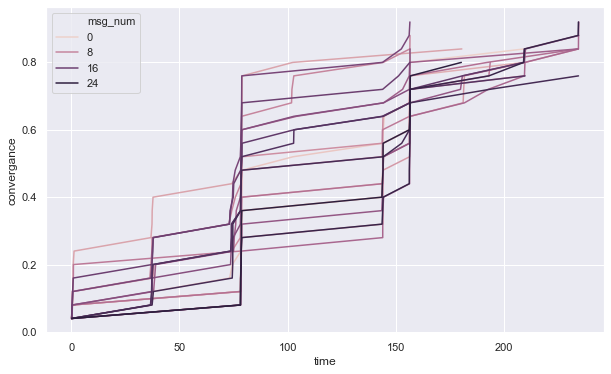

In [13]:
def conv(df):
    num_peers = len(df.columns)
    num_messages = len(df.index)
    
    
    a = df.values
    a.sort(axis=1)
    df2 = pd.DataFrame(a)
 

    df2.columns = ((i+1)/num_peers for i in df2.columns)
    df2.index = pd.RangeIndex(start=1, stop=num_messages+1, step=1)

    return df2.stack().reset_index().rename(columns={'level_0':'msg_num', 'level_1':'convergance', 0: 'time'})

def show_convergence(df):
    plt.figure(figsize=(10,6))
    sns.lineplot(x='time', y='convergance', data=conv(df), ci='sd', estimator="median", hue='msg_num')
    
show_convergence(df)

As it is clear, our gossip protocol with these parameters is not sufficient to guarantee full convergence. What can we do to improve it? 


# Achieving full convergence 


This is an exploratory section where you have one task: **full convergence**.

Possible options: 

1. Tweak parameter of gossip protocol. Change `ttl` and `fanout`. But keep in mind that will increase the load on the network. As our gossip protocol is blind, it might take a lot of resources to guarantee convergence. Also, `ttl` and `fanout` highly depend on the network topology. Try to change that, what is optimal `ttl` as a function of the number of peers?     


2. Change the network topology. What is an optimal topology for convergence?  


3. Implement better gossip protocol. We were using a naive gossip, but there better variations based on [rumor-mongering and anti-entropy](http://www.cs.cornell.edu/courses/cs6410/2016fa/slides/19-p2p-gossip.pdf). 
   
   A good start will be change gossip protocol to *pull-based* instead of *push-based*. 






## Tweaking parameters

For the reference we will change parameters and look at the convergence.


In [21]:
from p2psimpy.simulation import BaseSimulation

class GossipConfig(Config):
    fanout = 6 # To how many peers gossip the message 
    exclude_types={'client',} # Exlude clients from the gossip


class InitMessageConfig(Config):
    init_ttl= 3  # ttl of the message  

peer_types = {
            'peer': PeerType(PeerConfig,   {BaseConnectionManager: None,
                                            GossipService: GossipConfig }),
            'client': PeerType(PeerConfig, {BaseConnectionManager: None, 
                                            MessageProducer: InitMessageConfig})
         }

# init simulation, but change the parameters 
sim = BaseSimulation(Locations, G, peer_types)
sim.run(5_200)

{'peer': PeerType(config=<class '__main__.PeerConfig'>, service_map={<class 'p2psimpy.services.connection_manager.BaseConnectionManager'>: None, <class '__main__.GossipService'>: <class '__main__.GossipConfig'>}), 'client': PeerType(config=<class '__main__.PeerConfig'>, service_map={<class 'p2psimpy.services.connection_manager.BaseConnectionManager'>: None, <class '__main__.MessageProducer'>: <class '__main__.InitMessageConfig'>})}


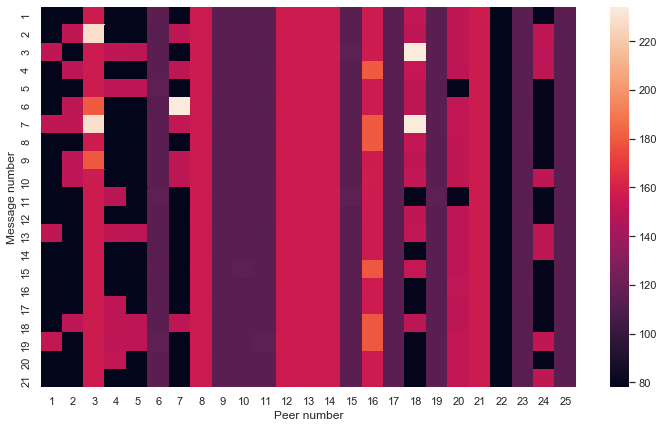

In [22]:
df = get_gossip_table(sim, 'msg_time')
show_heat_map(df)

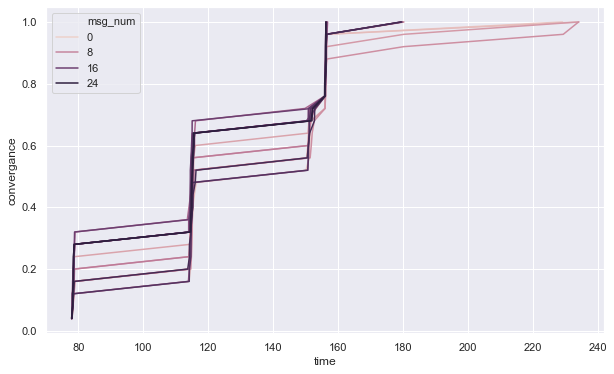

In [23]:
show_convergence(df)

We achieved convergence for this network topology. Once you change the topology, the guarantees are no longer there.

But what is the overhead of out gossip protocol? Default `Storage` has `times_seen` counter that keeps track of message updates.  Let's take a look:

In [24]:
sim.peers[12].storage['msg_time'].times_seen

{'1_26': 9,
 '2_26': 6,
 '3_26': 11,
 '4_26': 8,
 '5_26': 10,
 '6_26': 6,
 '7_26': 7,
 '8_26': 9,
 '9_26': 6,
 '10_26': 9,
 '11_26': 9,
 '12_26': 10,
 '13_26': 8,
 '14_26': 8,
 '15_26': 6,
 '16_26': 12,
 '17_26': 8,
 '18_26': 6,
 '19_26': 8,
 '20_26': 10,
 '21_26': 6}

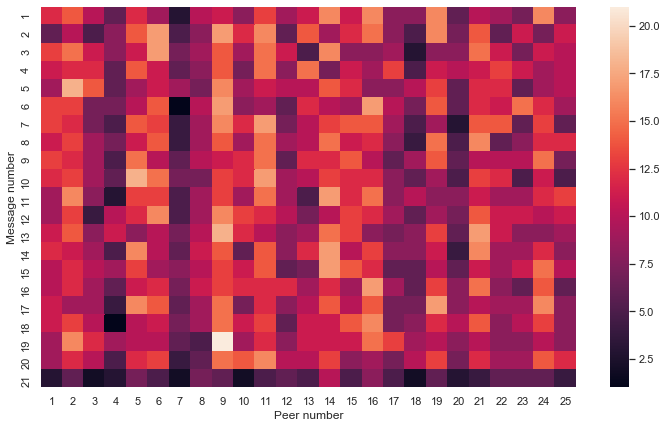

In [25]:
def calc_overhead(sim, peer_id, storage_name):
    store = sim.peers[peer_id].storage[storage_name].times_seen
    for k, times in store.items():
        msg_num, client_id = k.split('_')
        yield (int(msg_num), int(times))
    
def get_overhead_table(sim, storage_name):
    return pd.DataFrame({k: dict(calc_overhead(sim, k, storage_name)) 
                         for k in sim.types_peers['peer']}).sort_index()

oh = get_overhead_table(sim, 'msg_time')
show_heat_map(oh)            

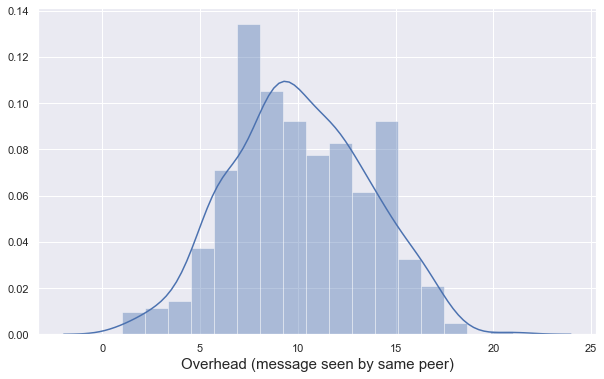

In [26]:
# Show average overhead on message
def show_overhead_hist(overhead_table):
    plt.figure(figsize=(10, 6))
    sns.distplot(overhead_table, norm_hist=True)
    plt.xlabel('Overhead (message seen by same peer)', fontsize=15)

show_overhead_hist(oh)

Finally, for reproducibility we will save the experiment data. Use `.save_experiment` to save configurations for your experiment: locations, topology and peer services. 

As a parameter function requires directory path to save experiments. Whole experiment will be saved in there yaml files. As they are saved in human readable format, you can always open and read the experiment data.

By default, it will not save the reference to implementations as it is not always [safe to do](https://github.com/yaml/pyyaml/wiki/PyYAML-yaml.load(input)-Deprecation). But if you are confident enough that other notebooks can find the service implementation feel free to use `include_module_classes=True`. 

For example, `GossipService` and `MessageProducer` cannot be saved as they are defined only within the scope of one notebook. If you want to include also implementations of services make sure to save them first somewhere where other notebooks can find it, e.g. to save into `py` file in `p2psimpy.services` module. 

For now we will save in safe mode


In [27]:
sim.save_experiment(expr_dir='gossip_expr')

As you can see the overhead is quite big. Can you decrease it while still converging?  


-----------------

## Your experiments here